# HU Extension       Assignment 09             E63 Big Data Analytics 		                  	
## Handed out: 03/31/2023                             Due by 6 PM EST on Saturday, 04/08/2023
### Emmanuel Aboah

### Problem 1. 
Using the bike dataset and GraphFrames API establish which stations participate in the largest number of rings of length 2. A ring of length 2 exists if you could identify 2 trips between stations a and b, and b and a, occurring in an immediate succession and within one calendar day. This does not mean that the same person completed both stretches. We do not have enough information. Operators of bike rentals do have the information since they track individual riders by their membership id or credit card number. Order the pairs of stations by the descending number of such circular trips. Display top 8 results 

In [5]:
# Imports
import findspark
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *

findspark.init()

spark_version = '3.3.1'
scala_version = '2.12'
neo4j_url = "bolt://localhost:7687"

'''
    Import jars from maven central.
    Follows Format -> groupId:artifactId:version
'''
packages = [
    'graphframes:graphframes:0.8.1-spark3.0-s_2.12',
    f'org.neo4j:neo4j-connector-apache-spark_{scala_version}:5.0.1_for_spark_3'
]

# Session Builder
spark = (
    SparkSession.builder
    .appName("grapframes_app")
    .config("spark.jars.packages", ",".join(packages))
    .config("spark.neo4j.bolt.url", neo4j_url)
    .getOrCreate()
)

sc = SparkContext.getOrCreate()

sc.setLogLevel("ERROR")

In [6]:
# Load bike data

bike_stations =(
    spark.read
    .option("header", "true")
    .csv("./bike-data/station_data.csv")
)

trip_data = (
    spark.read
    .option("header", "true")
    .csv("./bike-data/trip_data.csv")
)

bike_stations.printSchema()
trip_data.printSchema()

root
 |-- station_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- dockcount: string (nullable = true)
 |-- landmark: string (nullable = true)
 |-- installation: string (nullable = true)

root
 |-- Trip ID: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- Start Station: string (nullable = true)
 |-- Start Terminal: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- End Station: string (nullable = true)
 |-- End Terminal: string (nullable = true)
 |-- Bike #: string (nullable = true)
 |-- Subscriber Type: string (nullable = true)
 |-- Zip Code: string (nullable = true)



In [7]:
# Rename vertices Id's.
bike_station_vertices = (
    bike_stations
    .withColumnRenamed("name", "id")
    .distinct()
)

# Rename edges, src -> dest
trip_edges = (
    trip_data
    .withColumnRenamed("Start Station", "src")
    .withColumnRenamed("End Station", "dst")
)

In [8]:
# Import graphframes api
from graphframes import GraphFrame

spark.conf.set("spark.sql.shuffle.partitions", "4")

# Create Graph
bike_station_g = GraphFrame(bike_station_vertices, trip_edges)

bike_station_vertices.cache()
trip_edges.cache()

# Number of vertices
print(f"Total number of stations: {bike_station_g.vertices.count()}")

# Print edges
print(f"Total number of edges: {bike_station_g.edges.count()}")

# Print total number of trips
print(f"Total number of trips: {trip_data.count()}")

# Schema for vertices and edges
bike_station_g.vertices.printSchema()
bike_station_g.edges.printSchema()


/home/manny/anaconda3/envs/BDA2023/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Total number of stations: 70


Total number of edges: 354152


Total number of trips: 354152
root
 |-- station_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- dockcount: string (nullable = true)
 |-- landmark: string (nullable = true)
 |-- installation: string (nullable = true)

root
 |-- Trip ID: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- src: string (nullable = true)
 |-- Start Terminal: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- End Terminal: string (nullable = true)
 |-- Bike #: string (nullable = true)
 |-- Subscriber Type: string (nullable = true)
 |-- Zip Code: string (nullable = true)



In [9]:
bike_station_g.vertices.limit(5).show()

+----------+--------------------+---------+-----------+---------+--------+------------+
|station_id|                  id|      lat|       long|dockcount|landmark|installation|
+----------+--------------------+---------+-----------+---------+--------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|San Jose|    8/6/2013|
|         6|    San Pedro Square|37.336721|-121.894074|       15|San Jose|    8/7/2013|
|         7|Paseo de San Antonio|37.333798|-121.886943|       15|San Jose|    8/7/2013|
|         8| San Salvador at 1st|37.330165|-121.885831|       15|San Jose|    8/5/2013|
|        11|         MLK Library|37.335885| -121.88566|       19|San Jose|    8/6/2013|
+----------+--------------------+---------+-----------+---------+--------+------------+



In [10]:
bike_station_g.edges.limit(5).show()

+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|                 src|Start Terminal|       End Date|                 dst|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913460|     765|8/31/2015 23:26|Harry Bridges Pla...|            50|8/31/2015 23:39|San Francisco Cal...|          70|   288|     Subscriber|    2139|
| 913459|    1036|8/31/2015 23:11|San Antonio Shopp...|            31|8/31/2015 23:28|Mountain View Cit...|          27|    35|     Subscriber|   95032|
| 913455|     307|8/31/2015 23:13|      Post at Kearny|            47|8/31/2015 23:18|   2nd at South Park|          64|   468|     Subscriber|   94107|
| 913454|     409|8/31/2015 23:10|  San Jose City Hall|            10|8/31/2015 23

In [11]:
"""
Find largest number of rings of length 2. A ring of length 2 exists if you could 
identify 2 trips between stations a and b, and b and a, occurring in 
an immediate succession and within one calendar day.
"""

# Use older syntax
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Import expr
# from pyspark.sql.functions import expr

# Using motifs
motifs = (
    bike_station_g
    .find("(a)-[e]->(b); (b)-[e2]->(a)") 
)

motifs.printSchema()

(motifs
 .selectExpr("a.id as start_station",
             "b.id as end_station",
             "to_timestamp(e.`Start Date`, 'MM/dd/yyyy HH:mm') as e_start_time",
             "to_timestamp(e.`End Date`, 'MM/dd/yyyy HH:mm') as e_end_time",
             "e.duration as to_duration",
             "to_timestamp(e2.`Start Date`, 'MM/dd/yyyy HH:mm') as e2_start_time",
             "to_timestamp(e2.`End Date`, 'MM/dd/yyyy HH:mm') as e2_end_time",
             "e2.duration as from_duration")
.where("(to_date(e_end_time) == to_date(e2_start_time))") # Filter for the same day
.where("e_end_time < e2_start_time") # Successive trip meaning the was a -> b then b <- a
.groupBy("start_station", "end_station").count().orderBy(desc("count")).limit(10)
).show()

/home/manny/anaconda3/envs/BDA2023/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


root
 |-- a: struct (nullable = false)
 |    |-- station_id: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- lat: string (nullable = true)
 |    |-- long: string (nullable = true)
 |    |-- dockcount: string (nullable = true)
 |    |-- landmark: string (nullable = true)
 |    |-- installation: string (nullable = true)
 |-- e: struct (nullable = false)
 |    |-- Trip ID: string (nullable = true)
 |    |-- Duration: string (nullable = true)
 |    |-- Start Date: string (nullable = true)
 |    |-- src: string (nullable = true)
 |    |-- Start Terminal: string (nullable = true)
 |    |-- End Date: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- End Terminal: string (nullable = true)
 |    |-- Bike #: string (nullable = true)
 |    |-- Subscriber Type: string (nullable = true)
 |    |-- Zip Code: string (nullable = true)
 |-- b: struct (nullable = false)
 |    |-- station_id: string (nullable = true)
 |    |-- id: string (nullable = true)

+--------------------+--------------------+-----+
|       start_station|         end_station|count|
+--------------------+--------------------+-----+
|Harry Bridges Pla...|     2nd at Townsend|22814|
|San Francisco Cal...|     Townsend at 7th|20938|
|     Townsend at 7th|San Francisco Cal...|16121|
|San Francisco Cal...|Temporary Transba...|13432|
|San Francisco Cal...|Embarcadero at Fo...|12456|
|Civic Center BART...|     Townsend at 7th|11629|
|  Powell Street BART|San Francisco Cal...|11607|
|   Steuart at Market|Embarcadero at Sa...|10877|
|   Steuart at Market|     2nd at Townsend|10795|
|   Market at Sansome|   2nd at South Park| 9623|
+--------------------+--------------------+-----+



# Problem 2. 
Using the bike dataset and GraphFrames API, identify the station which is connected to the smallest number of other stations. Find out how many trips were made between that least popular station and the stations connected to it for every hour of the day. Find a way to export that information to one or more CSV files and then load the information into a Neo4j database. In Neo4j database, create a graph with that station in the middle and connected stations surrounding it. Let every spoke of the star be labeled with the number of trips between two stations. On the Spark side formulate a query that determines the peak hour of incoming and the peak hour of outgoing traffic on that station.

In [12]:
# Using the bike dataset and GraphFrames API, 
# identify the station which is connected to the smallest number of other stations.

# Trips from station to station
station_degrees = bike_station_g.degrees.orderBy(asc("degree")).limit(1).show()

+-----------------+------+
|               id|degree|
+-----------------+------+
|Franklin at Maple|   181|
+-----------------+------+



In [13]:
# Find out how many trips were made between that least popular station 
# and the stations connected to it for every hour of the day.
franklin_maple_trips = (
    bike_station_g.edges
    .where("src = 'Franklin at Maple' OR dst = 'Franklin at Maple'")
    .groupBy("src", "dst", hour(to_timestamp("Start Date", "MM/dd/yyyy HH:mm")).alias("start_hr_of_day"))
    .count()
    .orderBy(asc("start_hr_of_day"))
)

franklin_maple_trips.show(20)

+--------------------+--------------------+---------------+-----+
|                 src|                 dst|start_hr_of_day|count|
+--------------------+--------------------+---------------+-----+
|   Franklin at Maple|Stanford in Redwo...|              0|    1|
|Redwood City Publ...|   Franklin at Maple|              1|    1|
|San Antonio Caltr...|   Franklin at Maple|              2|    1|
|Redwood City Publ...|   Franklin at Maple|              2|    1|
|   Franklin at Maple|Redwood City Publ...|              5|    1|
|Redwood City Medi...|   Franklin at Maple|              6|    2|
|   Franklin at Maple|Redwood City Calt...|              6|    1|
|   Franklin at Maple|Redwood City Calt...|              7|   22|
|   Franklin at Maple|Redwood City Publ...|              7|    2|
|   Franklin at Maple|          Mezes Park|              7|    1|
|   Franklin at Maple|Redwood City Calt...|              8|    2|
|Redwood City Calt...|   Franklin at Maple|              8|    1|
|   Frankl

In [14]:
# Find a way to export that information to one or more CSV files

(
    franklin_maple_trips
    .write
    .option("header", True)
    .csv("./output")
)

```bash
# load the information into a Neo4j database.

# copy csv files
docker cp output/franklin_maple_trips.csv neo4j:/var/lib/neo4j/import

# load data into neo4j database
@manny> LOAD CSV WITH HEADERS FROM "file:///franklin_maple_trips.csv" as line
        MERGE (src:Station {id:line.src})
        MERGE (dst:Station {id:line.dst})
        CREATE
        (src)-[:TRIPS {total_trips: [line.count]}]->(dst);
@manny>
```

In Neo4j database, create a graph with that station in the middle and connected stations surrounding it. Let every spoke of the star be labeled with the number of trips between two stations.

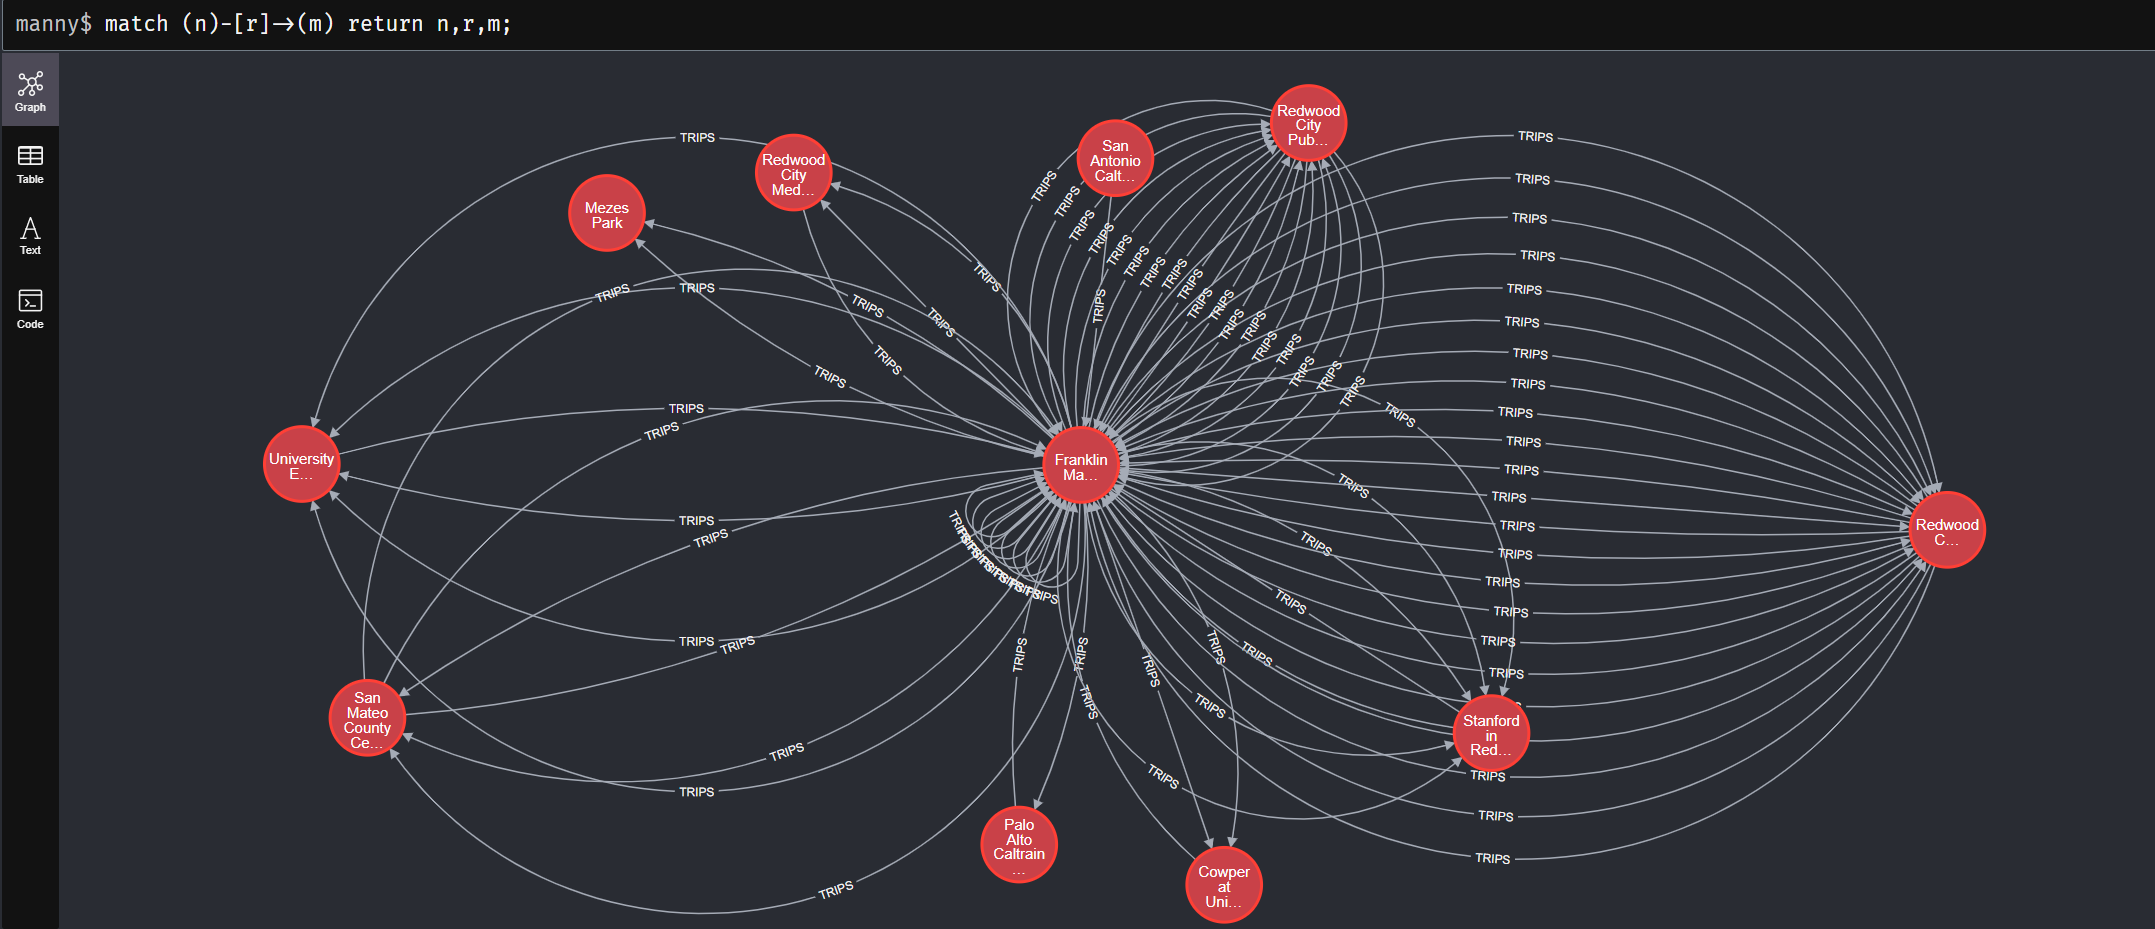

On the Spark side formulate a query that determines the peak hour of incoming and the peak hour of outgoing traffic on that station.

In [15]:
# Peak hour incoming traffic
peak_incoming = (
    bike_station_g.edges
    .where("dst = 'Franklin at Maple'")
    .groupBy("dst", hour(to_timestamp("end Date", "MM/dd/yyyy HH:mm")).alias("peak_incoming_hr_of_day"))
    .count()
    .orderBy(desc("count"))
    .limit(1)
)

peak_incoming.show()

+-----------------+-----------------------+-----+
|              dst|peak_incoming_hr_of_day|count|
+-----------------+-----------------------+-----+
|Franklin at Maple|                     18|   29|
+-----------------+-----------------------+-----+



In [16]:
# Peak hour outgoing traffic
peak_incoming = (
    bike_station_g.edges
    .where("src = 'Franklin at Maple'")
    .groupBy("src", hour(to_timestamp("Start Date", "MM/dd/yyyy HH:mm")).alias("peak_outgoing_hr_of_day"))
    .count()
    .orderBy(desc("count"))
    .limit(1)
)

peak_incoming.show()

+-----------------+-----------------------+-----+
|              src|peak_outgoing_hr_of_day|count|
+-----------------+-----------------------+-----+
|Franklin at Maple|                      7|   25|
+-----------------+-----------------------+-----+



# Problem 3.
In the lab notebook, Lab09_GraphFrames we used an example graph. We loaded that graph by saying:
from graphframes.examples import Graphs
g = Graphs(spark).friends()  # Get example graph
Please use routine nx.draw() from package NetworkX to draw that imported graph first.  Then draw a graph similar to the one you created in Problem 2, using Neo4J.

In [17]:
# Import friends example graph

from graphframes.examples import Graphs
import networkx as nx
import matplotlib.pyplot as plt

sqlContext = SQLContext(sc)

g = Graphs(sqlContext).friends()  # Get example graph

v = g.vertices.toPandas()
e = g.edges.toPandas()

vertex_dict = v.to_dict(orient= 'list')
edge_dict = e.to_dict(orient= 'list')

print(vertex_dict)
print(edge_dict)


/home/manny/anaconda3/envs/BDA2023/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/manny/anaconda3/envs/BDA2023/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


{'id': ['a', 'b', 'c', 'd', 'e', 'f'], 'name': ['Alice', 'Bob', 'Charlie', 'David', 'Esther', 'Fanny'], 'age': [34, 36, 30, 29, 32, 36]}
{'src': ['a', 'b', 'c', 'f', 'e', 'e', 'd'], 'dst': ['b', 'c', 'b', 'c', 'f', 'd', 'a'], 'relationship': ['friend', 'follow', 'follow', 'follow', 'follow', 'friend', 'friend']}


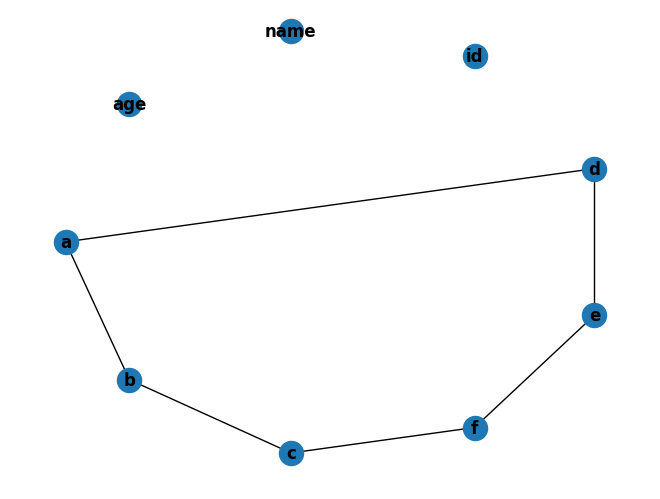

In [18]:
# Plot the graph
%matplotlib inline

gp = nx.convert_matrix.from_pandas_edgelist(df=g.edges.toPandas(), 
                                            source="src", 
                                            target="dst", 
                                            edge_attr="relationship")

gp.add_nodes_from(vertex_dict)

nx.drawing.nx_pylab.draw_shell(gp, with_labels=True, font_weight="bold")
plt.show()

Save to neo4j

In [19]:
vertices_df: DataFrame = g.vertices
edges_df: DataFrame = g.edges

vertices_df.show()
edges_df.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



In [69]:
# Save vertices to parquet
vertices_df.coalesce(1).write.option("header", True).csv("./vertices_output")

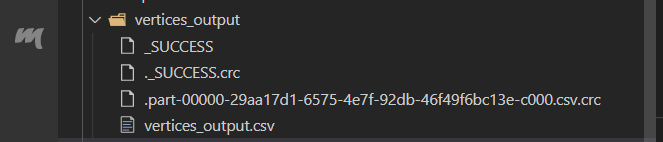

In [71]:
# Save egdes to parquet
edges_df.coalesce(1).write.option("header", True).csv("./edges_output")

Output...

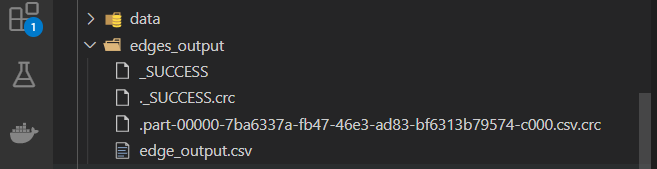

Copy csv files to docker

```bash
(base) manny@LAPTOP-85L1BUVJ:~/dev/cscie-63/hw09$ docker cp vertices_output/vertices_output.csv neo4j:/var/lib/neo4j/import
(base) manny@LAPTOP-85L1BUVJ:~/dev/cscie-63/hw09$ docker cp edges_output/edge_output.csv neo4j:/var/lib/neo4j/import
```

load in cypher-shell

```bash
# Create Person nodes
neo4j@neo4j> LOAD CSV WITH HEADERS FROM "file:///vertices_output.csv" AS line
             CREATE (p:Person {id:line.id, name:line.name, age:line.aga});
0 rows
ready to start consuming query after 15 ms, results consumed after another 0 ms
Added 6 nodes, Set 12 properties, Added 6 labels
# Create Relationship edges
neo4j@neo4j> LOAD CSV WITH HEADERS FROM "file:///edge_output.csv" as line
             MATCH (src:Person {id:line.src})
             MATCH (dst:Person {id:line.dst})
             CREATE (src)-[:RELATIONSHIP {relationships: [line.relationship]}]->(dst);
0 rows
ready to start consuming query after 15 ms, results consumed after another 0 ms
Created 7 relationships, Set 7 properties
```

Display Graph

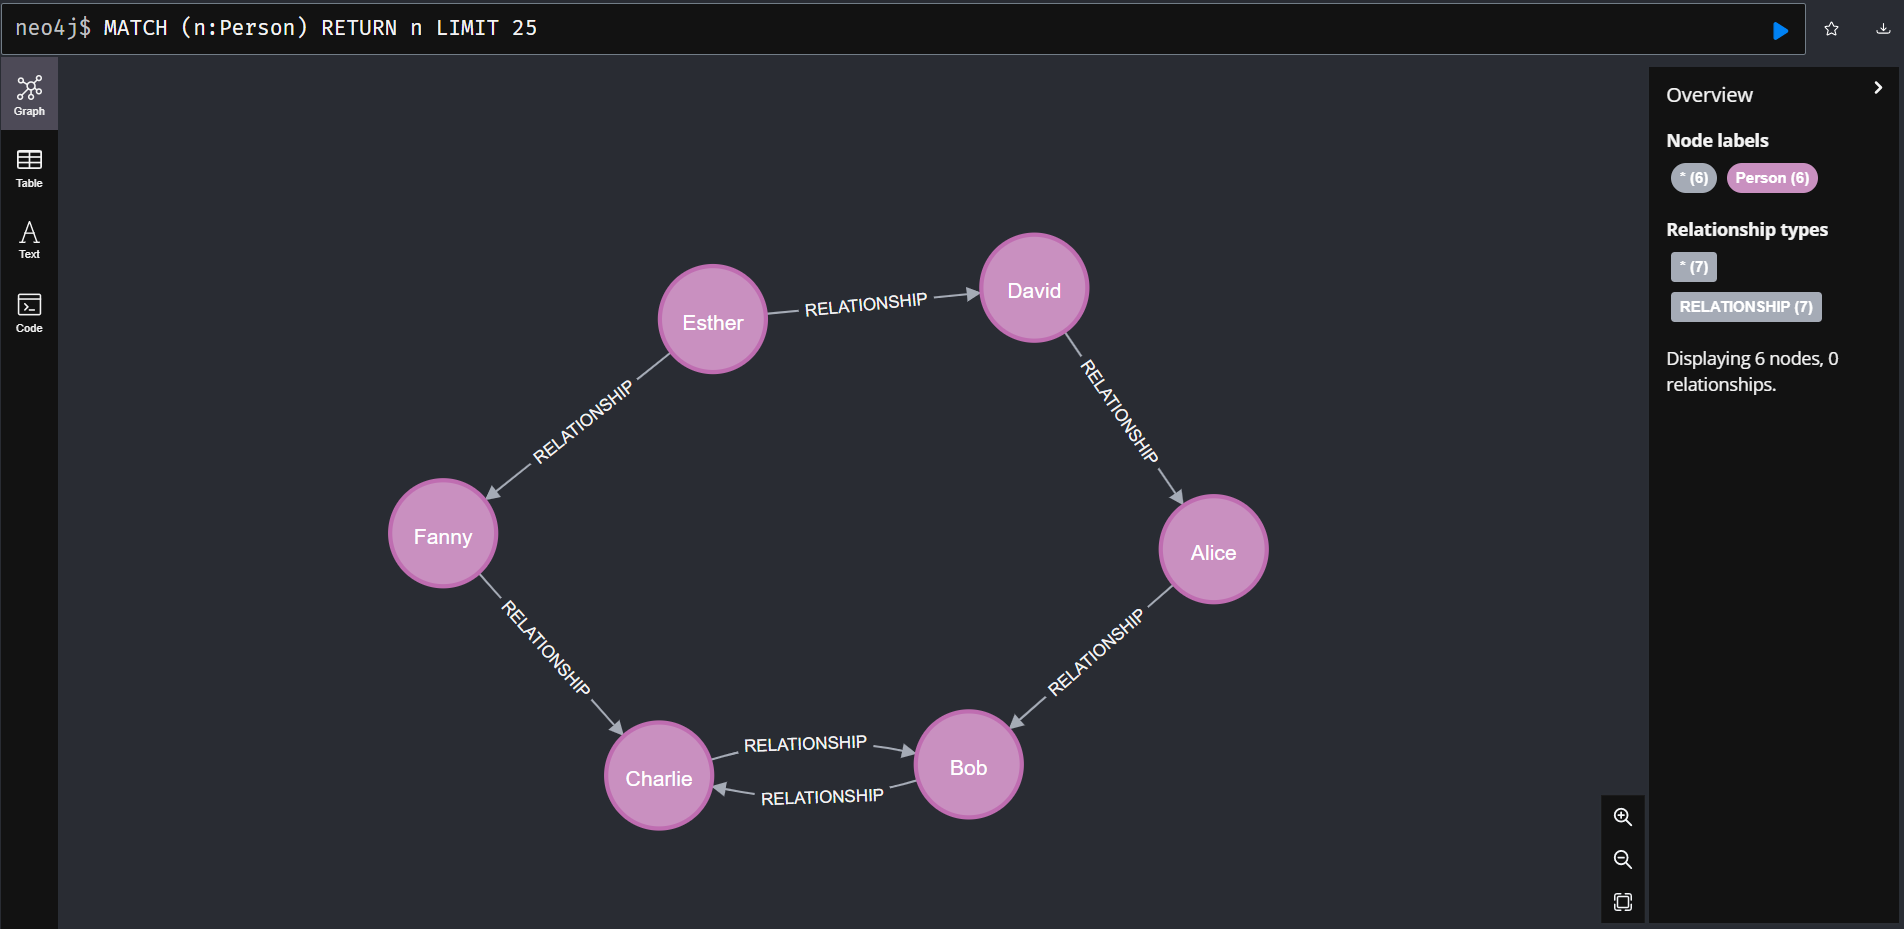

# Problem 4. 

There is a library called Neo4j-Spark Connector that allows you to transfer graph data between Neo4j and Spark without CSV exports.  Demonstrate that you can transfer data from Neo4j movies database into Spark. Perform a simple query in Spark to identify all the movies Tom Hanks participated in. 

In [80]:
(
spark.read
.format("org.neo4j.spark.DataSource")
.option("url", "bolt://localhost:7687")
.option("query", 
        "MATCH (n:Person)-[r]->(m:Movie) RETURN n.name as name,"
        + " r as role, m.title as title")
.option("authentication.basic.username", "neo4j")
.option("authentication.basic.password", "password")
.load()
.where("name = 'Tom Hanks'")
.show()
)

+---------+--------------------+--------------------+
|     name|                role|               title|
+---------+--------------------+--------------------+
|Tom Hanks|{107, ACTED_IN, 7...|     You've Got Mail|
|Tom Hanks|{114, ACTED_IN, 7...|Sleepless in Seattle|
|Tom Hanks|{121, ACTED_IN, 7...|Joe Versus the Vo...|
|Tom Hanks|{133, ACTED_IN, 7...|   That Thing You Do|
|Tom Hanks|{136, DIRECTED, 7...|   That Thing You Do|
|Tom Hanks|{160, ACTED_IN, 7...|         Cloud Atlas|
|Tom Hanks|{169, ACTED_IN, 7...|   The Da Vinci Code|
|Tom Hanks|{205, ACTED_IN, 7...|      The Green Mile|
|Tom Hanks|{225, ACTED_IN, 7...|           Apollo 13|
|Tom Hanks|{236, ACTED_IN, 7...|           Cast Away|
|Tom Hanks|{251, ACTED_IN, 7...|Charlie Wilson's War|
|Tom Hanks|{3, ACTED_IN, 71,...|   The Polar Express|
|Tom Hanks|{5, ACTED_IN, 71,...|A League of Their...|
+---------+--------------------+--------------------+

